In [31]:
import os
import re
import numpy as np
import pandas as pd
from datetime import date, datetime
from calendar import monthrange
from IPython.display import display,HTML
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", None)
pd.set_option("display.expand_frame_repr", False)
from DataProcessing import import_data,property_input,format_reservation
# -------------------------------------------------------------------
# Small helpers
# -------------------------------------------------------------------

def days_in_month_from_yearmonth(ym: str) -> int:
    """ym like '2024-05' -> number of days in that month."""
    y, m = map(int, ym.split("-"))
    return monthrange(y, m)[1]

def to_yearmonth(dtcol: pd.Series) -> pd.Series:
    return pd.to_datetime(dtcol).dt.strftime("%Y-%m")

def substr_year(s: str) -> str:
    return s[:4]

def safe_round(df: pd.DataFrame, ndigits: int = 2) -> pd.DataFrame:
    num = df.select_dtypes(include=[np.number]).columns
    df[num] = df[num].round(ndigits)
    return df

In [32]:
# ---- normalize Property: if starts with number, swap order ----
def reorder_property(name):
    if isinstance(name, str):
        parts = name.split()
        if len(parts) == 2 and parts[0].isdigit():
            return f"{parts[1]} {parts[0]}"
    return name

# Owner payouts (2024–2025)
# -------------------------------------------------------------------
def build_owner_payout(endmonth):
    pay_path = "/Users/ylin/My Drive/Cohost/Accounting/"
    y25 = [f"2025.{m:02d}" for m in range(1, 13)]
    y24 = [s.replace("2025","2024") for s in y25]
    owner_payout = []
    # First pass: sheets from 2024.12 and 2025.01–09 in "01-OwnerPayout Records.xlsx"\\
    for k in [y24[11], *y25[:11]]:  
        tmp = pd.read_excel(pay_path+"/* Monthly/0-Process & Template/Old files/2025 OwnerPayout Records.xlsx", sheet_name=k)
        idx = tmp["Date"].notna() & (tmp['Payout'].notna()) & (tmp['Payout'] != 0)
        tmp["Date"]=k
        take = tmp.loc[idx, ["Date","Property","Payout"]].copy()
        owner_payout.append(take)
        
    # Second pass: earlier 2024 sheets from legacy workbook
    old_path = pay_path+"/* Monthly/0-Process & Template/Old files/2024 OwnerPayout Records.xlsx"
    for k in ["2023.12", *y24[:11]]:
        tmp = pd.read_excel(old_path, sheet_name=k)
        if k =="2023.12":
            idx = (tmp['Owner payout'].notna()) & (tmp['Owner payout'] != 0) &(tmp["Property"].str.contains("Total")==False)
            take = tmp.loc[idx, ["Property","Owner payout"]].copy()
            take.insert(0, "Date", k)
            take.columns = ["Date","Property","Payout"]
            take["Property"] = take["Property"].apply(reorder_property)
            take["Property"] = take["Property"].apply(lambda x: x.capitalize() if isinstance(x, str) else x)
        else:
            if k != "2024.11":
                idx = (tmp['Payout'].notna()) & (tmp['Payout'] != 0) &(tmp["Property"].str.contains("Total")==False)
                take = tmp.loc[idx, ["Property","Payout"]].copy()
                take.insert(0, "Date", k)
            else:
                idx = tmp["Date"].notna() & (tmp['Payout'].notna()) & (tmp['Payout'] != 0) & (tmp["Property"].str.contains("Total")==False)
                take = tmp.loc[idx, ["Date","Property","Payout"]].copy()
                take["Date"] = take["Date"].astype(str)   
        owner_payout.append(take)

    owner_payout = pd.DataFrame(pd.concat(owner_payout, ignore_index=True))
    owner_payout["PayPeriod"] = owner_payout["Date"]
    owner_payout["Date"]= pd.to_datetime(owner_payout["Date"],format="%Y.%m") + pd.DateOffset(months=1)
    owner_payout["Date"]= owner_payout["Date"].astype(str).str[:7]

    # Manually add Jing's property payouts
    jing_property = pd.DataFrame({"Date":["2024.05"]*4+["2024.06"]*4+["2024.07"]*4,
                    "Property":["Elektra 1004", "Elektra 1108","Elektra 1115","Microsoft 14615-D303"]*3,
                    "Payout": [-325.99,3942.64,1627.11,3150.69, 4345.90,1249.86,3954.50,3929.28,\
                            1824.40,2392.14,3247.69,4060.26]})
    idx = owner_payout['Property'].str.contains("Jing", na=False)
    owner_payout = pd.concat([owner_payout.loc[~idx], jing_property], ignore_index=True)
    owner_payout["Year"] = owner_payout["Date"].str[:4]
    owner_payout["yearmonth"] = owner_payout["Date"]#.str.replace(".", "-")
    owner_payout["Property"] = owner_payout["Property"].str.strip()
    owner_payout["Property"] = owner_payout["Property"].str.replace(r"\bIsland\s+", "", regex=True)
    owner_payout["Property"] = owner_payout["Property"].str.replace("SeaTac", "Seatac", regex=False)

    # Recode property names
    txt = [
        "Microsoft 14645 C19","Microsoft 14620 E205","E205","D201",
        "Kirkland D201","Kirkland 11321 - corrected","OSBR - All","OSBR",
        "Burien 14407 Middle","Burien 14407 Top","Seatac 12834 - Lower",
        "Seatac 12834 - Upper","Bellevue 13020 - already paid","Seattle 906",
        "1424c seattle",'1430b seattle',"C19 bellevue",
    ]
    change = [
        "Microsoft 14645-C19","Microsoft 14620-E205","Total","Kirkland 8252-D201",
        "Kirkland 8252-D201","Kirkland 11321","Cottages All OSBR","Cottages All OSBR",
        "Burien 14407 middle","Burien 14407 top","Seatac 12834 Lower",
        "Seatac 12834 Upper","Bellevue 13020","Seattle 906 Lower",
        "Seattle 1424C","Seattle 1430B","Microsoft 14645-C19",
    ]
    mapping = dict(zip(txt, change))
    owner_payout["Property"] = owner_payout["Property"].replace(mapping)

    # Filter out specific duplicate line
    mask_dupe = (
        (owner_payout["Property"] == "Kirkland 11321") &
        (owner_payout["yearmonth"] == "2024-04") &
        (owner_payout["Payout"] == 1515.68)
    )
    owner_payout = owner_payout.loc[~mask_dupe].copy()

    # Collapse to (Property, yearmonth)
    owner_payout = (
        owner_payout.loc[~owner_payout["Property"].astype(str).str.contains("Total", na=False)]
        .dropna(subset=["Payout"])
    )
    owner_payout = owner_payout[owner_payout["Payout"] != 0]
    owner_payout = (
        owner_payout.groupby(["Property", "yearmonth"], as_index=False)
        .agg(Year=("yearmonth", lambda s: s.iloc[0][:4]), Payout=("Payout", "sum"))
        .drop_duplicates()
    )
    owner_payout.loc[owner_payout["Property"]=="Bellevue 14507","Property"] = "Bellevue 14507U3"
    owner_payout["Payout"]= pd.to_numeric(owner_payout["Payout"], errors="coerce")

    # OwnerPayout wide by Year
    owner_dist = (
        owner_payout.groupby(["Year", "Property"], as_index=False)["Payout"].sum()
        .rename(columns={"Payout": "OwnserDist"})
    )
    owner_dist = owner_dist[(owner_dist["OwnserDist"] > 0) & owner_dist["Property"].notna()]
    owner_wide = owner_dist.pivot(index="Property", columns="Year", values="OwnserDist").reset_index()
    owner_wide.columns.name = None  # remove MultiIndex name
    owner_wide = owner_wide.rename(columns={"Property": "Listing"})

    comb_data = owner_wide[owner_wide["Listing"].str.contains(r"Beachwood", case=False, na=False)]
    num_col1 = comb_data.select_dtypes(include=[np.number]).columns
    comb_sum = comb_data.assign(Listing="Beachwood").groupby("Listing", as_index=False).agg({c:"sum" for c in num_col1})

    mask = owner_wide["Listing"].str.contains(r"Beachwood", case=False, na=False)
    owner_wide = pd.concat([owner_wide[~mask],comb_sum],ignore_index=True)
    return owner_payout, owner_wide

In [33]:
def cal_occupancy(data):
    """Calculate occupancy rate by listing and yearmonth."""
    daily = (
        data[["checkin_date","checkout_date","Confirmation.Code","Listing",\
            "DailyListingPrice","AvgDailyRate","Term"]].copy()
    )
    daily["checkin_date"] = pd.to_datetime(daily["checkin_date"])
    daily["checkout_date"] = pd.to_datetime(daily["checkout_date"])
    # Create list of dates per row (nights only: exclude checkout)
    daily["date_list"] = daily.apply(
        lambda r: pd.date_range(r["checkin_date"], r["checkout_date"] - pd.Timedelta(days=1), freq="D")
        if pd.notna(r["checkin_date"]) and pd.notna(r["checkout_date"]) and r["checkout_date"] > r["checkin_date"]
        else pd.DatetimeIndex([], dtype="datetime64[ns]"),
        axis=1
    )
    daily = daily.explode("date_list").rename(columns={"date_list": "date"}).dropna(subset=["date"])
    daily["yearmonth"] = to_yearmonth(daily["date"])
    daily["Year"] = daily["date"].dt.strftime("%Y")
    daily["Month"] = daily["date"].dt.strftime("%m")

    # Occupancy & revenue (by stayed-nights)
    occ = (
        daily.groupby(["Listing","yearmonth","Year","Month"], as_index=False)
        .agg(
            occdays=("date", "count"),
            Revenue_occ=("DailyListingPrice", "sum"),
            Revenue_occ_accom=("AvgDailyRate","sum"),
            minADR = ("AvgDailyRate","min"),
            maxADR = ("AvgDailyRate","max"),
            avgADR = ("AvgDailyRate","mean"),
            medADR = ("AvgDailyRate","median"),
        )
    )
    occ["OccRt"] = occ["yearmonth"].map(lambda ym: occ.loc[occ["yearmonth"].eq(ym), "occdays"].iloc[0])  # placeholder
    # Compute OccRt properly per row:
    occ["OccRt"] = occ["yearmonth"].apply(lambda ym: np.nan)  # will replace below
    occ["OccRt"] = occ["occdays"] / occ["yearmonth"].apply(days_in_month_from_yearmonth)
    return occ,daily

def yoy_delta(monthly_tab, monthly, prev: str, curr: str) -> pd.DataFrame:
    """Calculate year-over-year delta and percentage change between two years.""" 
    delta_col = f"RevenueIncr{prev}{curr}"
    perc_col = f"RevenueIncr{prev}{curr}_perc"
    monthly_tab = monthly_tab.assign(
        **{
            delta_col: monthly_tab[f"Revenue_{curr}"] - monthly_tab[f"Revenue_{prev}"],
            perc_col: (monthly_tab[f"Revenue_{curr}"] - monthly_tab[f"Revenue_{prev}"]) / monthly_tab[f"Revenue_{prev}"]
        }
    )
    # Append YoY increments back to monthly (per yearmonth)
    rev_incr = monthly_tab[["Listing","Month",delta_col,perc_col]].copy()
    rev_incr["yearmonth"] = curr + "-" + rev_incr["Month"].astype(str)
    rev_incr = rev_incr.rename(columns={delta_col: "RevenueIncr", perc_col: "RevenueIncr_perc"})
    rev_incr = rev_incr[["Listing","yearmonth","RevenueIncr","RevenueIncr_perc"]]
    return monthly_tab,rev_incr

def combine_osbr_beachwood(yearly_table):
    """Combine OSBR and Beachwood listings into a single entry."""
    osbr_data = yearly_table[yearly_table["Listing"].str.contains(r"Cottage|OSBR", case=False, na=False)]
    osbr_data
    osbr_summary = (
        osbr_data.assign(Listing="Cottages All OSBR").groupby("Listing")
        .agg(
            Revenue_2024=("Revenue_2024", "sum"),
            Revenue_2025=("Revenue_2025", "sum")
        ).reset_index()
    )
    # Remove individual OSBR and Beachwood entries
    beachwood = yearly_table[yearly_table["Listing"].str.contains(r"Beachwood", case=False, na=False)]
    beachwood_summary = (beachwood.assign(Listing="Beachwood").groupby("Listing")
                        .agg(
            Revenue_2024=("Revenue_2024", "sum"),
            Revenue_2025=("Revenue_2025", "sum")).reset_index()
            )
    # Append combined entry
    mask = yearly_table["Listing"].str.contains(r"Cottage|OSBR|Beachwood", case=False, na=False)
    yearly_table = pd.concat([yearly_table[~mask], osbr_summary,beachwood_summary], 
                             ignore_index=True)
    return yearly_table

In [34]:
# Guesty bookiing records
# Exclusions + rename Ocean Spray 3 -> Cottage 3
data = import_data()
excl = {"Bellevue 4551","Bothell 21833","NorthBend 44406","Ashford 137","Auburn 29123","Hoquiam 21"}
data = data[~data["Listing"].isin(excl)].copy()
data = data[~((data["booking_source"]=="owner")|(data["accommodation_fare"]==0))].copy()
data.loc[data["Listing"].eq("Seattle 3617 Origin"), "Listing"] = "Seattle 3617"
data.loc[data["Listing"].eq("Seattle 906"), "Listing"] = "Seattle 906 Lower"
occupancy, daily = cal_occupancy(data)

## Payout data : use pay time to merge with revenue, eg, payout in June for May revenue, 
#                2025 payout is for revenue 2024.12-2025.11
owner_payout, OwnerPayout = build_owner_payout(endmonth=11)
property = property_input()

In [35]:
#owner_payout,OwnerPayout=build_owner_payout(10)
monthly_STR =(data[data["Term"]=="STR"]
              .groupby(["Listing","yearmonth"],as_index=False)
              .agg(Revenue=("total_revenue","sum"))
              .merge(occupancy[["Listing","yearmonth","occdays","OccRt","Revenue_occ","Revenue_occ_accom","minADR","maxADR","avgADR","medADR"]],
                     on=["Listing","yearmonth"],how="outer")              
              )

monthly_STR["Revenue"].fillna(0)
monthly_STR["ADR"] = monthly_STR["Revenue_occ_accom"]/ monthly_STR["occdays"]

monthly_LTR = (daily[daily["Term"]=="LTR"]
               .groupby(["Listing","yearmonth"],as_index=False)
               .agg(occdays=("date", "count"),
                     Revenue_defer=("DailyListingPrice","sum"),
                     minADR = ("AvgDailyRate",'min'),
                     maxADR=("AvgDailyRate","max"),
                     avgADR = ("AvgDailyRate","mean"),
                     medADR = ("AvgDailyRate","median")
               ))
monthly_LTR["OccRt"] = monthly_LTR["occdays"] / monthly_LTR["yearmonth"].apply(days_in_month_from_yearmonth)

monthly = monthly_STR.merge(monthly_LTR,on=["Listing","yearmonth"],how="outer",suffixes=("","_LTR"))
monthly["Revenue"] = np.where(monthly["Revenue_defer"].isna(), monthly["Revenue"], monthly["Revenue_occ"])
monthly["Month"] = monthly["yearmonth"].str[5:7]
monthly["Year"] = monthly["yearmonth"].str[0:4]
monthly = monthly.merge(owner_payout[["Property","yearmonth","Payout"]], 
                        left_on=["Listing","yearmonth"], right_on=["Property","yearmonth"], how="left")

In [36]:
#select_listing = "Seattle 710"
#print(monthly.loc[monthly["Listing"]==select_listing,["Listing","yearmonth","minADR","avgADR","medADR"]].sort_values(by="minADR").head())
#data.loc[(data["Listing"]==select_listing) &(data["checkin_date"]>=pd.to_datetime('2024-01-01')),
#         ["Listing","Confirmation.Code","checkin_date","nights","accommodation_fare","AvgDailyRate"]].sort_values(by="AvgDailyRate").head()


In [37]:
# Monthly tab pivot wide by Year for (Revenue, ADR, OccRt, Payout)
# 12/17: STR only, 
values_to_wide = ["Revenue","ADR","OccRt"]
monthly_tab = monthly.merge(property[["Listing","Type","Status"]],on="Listing",how='outer')
idx =monthly_tab["Year"].isin(["2024","2025","2026"]) & (monthly_tab["Type"]=="STR") & (monthly_tab["Status"]=="Active")
monthly_tab = monthly_tab.loc[idx]
 # filter by year
wide = []
for val in values_to_wide:
    pivot = monthly_tab.pivot_table(index=["Listing","Month"], columns="Year", values=val, aggfunc="first")
    pivot.columns = [f"{val}_{c}" for c in pivot.columns]
    pivot = pivot.reset_index()
    wide.append(pivot) 
    
monthly_tab = wide[0]
for w in wide[1:]:
    monthly_tab = monthly_tab.merge(w, on=["Listing","Month"], how="outer")
monthly_tab = monthly_tab.sort_values(["Listing","Month"], kind="stable")
monthly_tab = safe_round(monthly_tab, ndigits=2)


monthly_tab,rev_incr25 =yoy_delta(monthly_tab,monthly, "2024", "2025")
monthly_tab,rev_incr26 =yoy_delta(monthly_tab,monthly, "2025", "2026")
monthly_tab = safe_round(monthly_tab, ndigits=2)
monthly_tab = monthly_tab[["Listing","Month","Revenue_2024","ADR_2024","OccRt_2024",
                           "Revenue_2025","ADR_2025","OccRt_2025","RevenueIncr20242025","RevenueIncr20242025_perc",
                           "Revenue_2026","ADR_2026","OccRt_2026","RevenueIncr20252026","RevenueIncr20252026_perc"]]


rev_incr= pd.concat([rev_incr25,rev_incr26],ignore_index=True)

monthly = monthly.merge(rev_incr,on=["Listing","yearmonth"],how="left")

In [38]:
# monthly_Q1 = monthly.loc[(monthly["Month"].isin(["01","02","03"])) &(monthly["Year"].isin(["2025","2026"]))]
# wide = []
# for val in values_to_wide:
#     pivot = monthly_Q1.pivot_table(index=["Listing"], columns="Year", values=val, aggfunc="first")
#     pivot.columns = [f"{val}_{c}" for c in pivot.columns]
#     pivot = pivot.reset_index()
#     wide.append(pivot) 
    
# monthly_Q1 = wide[0]
# for w in wide[1:]:
#     monthly_Q1 = monthly_Q1.merge(w, on=["Listing"], how="outer")
# monthly_Q1 = monthly_Q1.sort_values(["Listing"], kind="stable")
# monthly_Q1 = safe_round(monthly_Q1, ndigits=2)
# monthly_Q1.columns = monthly_Q1.columns[:1].tolist() + (monthly_Q1.columns[1:] + "_Q1").tolist()
# monthly_Q1 = property[["Listing","Type","Status"]].merge(monthly_Q1, on="Listing", how="left")

In [39]:
## Yearly summary pivot 
yearly = monthly.groupby(["Listing","Year"],as_index=False).agg(
    nights =("occdays","sum"),
    Revenue =("Revenue","sum"),
    ADR =("avgADR","mean")  # placeholder,
)
#yearly["ADR"] = yearly["Revenue"] / yearly["nights"]
yearly["OccRt"] = yearly["nights"] / yearly["Year"].apply(lambda y: 366 if int(y)%4==0 else 365)    
yearly = safe_round(yearly, ndigits=2)
tmp = pd.MultiIndex.from_product([["Revenue","ADR","OccRt"], [2024,2025]]).tolist()
cols = [f"{m[0]}_{m[1]}" for m in tmp]

yearly_tab = yearly[yearly["Year"].isin(["2024","2025"])].\
    pivot(index="Listing",  columns="Year",
          values=["Revenue","ADR","OccRt"]).reset_index()
yearly_tab.columns = ["Listing",*cols]

In [40]:
### ADR Range report
mask =(data["total_revenue"]==48.5)&(data["yearmonth"].isin(["2024-10","2024-11"]))|\
    (data["Confirmation.Code"].isin(["HMBE2E392M","HMQAWPFBSZ","HM5ZZBP4NK"]))
 # remove testing rent)].copy()

data_adr = data[(~mask) & (data["checkin_date"]>=pd.to_datetime('2024-01-01'))& (data["checkin_date"]<=pd.to_datetime('2025-12-31'))].\
    merge(property[["Listing","Set","Type","Status"]],on="Listing",how="left")
rangeADR = (data_adr
            .groupby(["Listing"],as_index=False)
            .agg(minADR=("AvgDailyRate","min"),
                 maxADR=("AvgDailyRate","max"),
                 avgADR=("AvgDailyRate","mean"),
                 medADR=("AvgDailyRate","median"),
                 bookings =("Confirmation.Code","nunique"),
                 start_date=("checkin_date","min"),
                 endd_ate=("checkout_date","max")))

rangeADR["start_date"] = rangeADR["start_date"].astype(str).str[:10]
rangeADR["end_date"] = rangeADR["endd_ate"].astype(str).str[:10]
rangeADR = safe_round(rangeADR, ndigits=2)

rangeADR_Set = (data_adr
                .groupby(["Set"],as_index=False)
                .agg(minADR=("AvgDailyRate","min"),
                     ADR005=("AvgDailyRate",lambda x: x.quantile(0.005)),
                     ADR025=("AvgDailyRate",lambda x: x.quantile(0.025)),
                     ADR16=("AvgDailyRate",lambda x: x.quantile(0.16)),
                     medADR=("AvgDailyRate","median"),
                     ADR84=("AvgDailyRate",lambda x: x.quantile(0.84)),
                     ADR90=("AvgDailyRate",lambda x: x.quantile(0.90)),
                     ADR95=("AvgDailyRate",lambda x: x.quantile(0.95)),
                     maxADR=("AvgDailyRate","max")))
rangeADR_Set = safe_round(rangeADR_Set, ndigits=2)

Ranges = (property[["Listing","Type","Status","BEDROOMS","Set"]]
          .merge(rangeADR,on="Listing",how="right")
          .merge(rangeADR_Set,on="Set",how="left",suffixes=("_Listing","_Set")))


In [41]:
## Valta Occ rate : STR only, by region
data_str = data_adr.loc[(data_adr["Status"]=="Active") & (data_adr["Type"]=="STR") & (data_adr["nights"]<=31)].copy()
data_str["Year"]=data_str["checkin_date"].dt.strftime("%Y")
data_str["Month"]=data_str["checkin_date"].dt.strftime("%m")
property = property_input()
occupancy_str,daily_str = cal_occupancy(data_str)
occ_valta = (occupancy_str.loc[occupancy_str["Year"]=="2025",["Listing","yearmonth","Year","Month","occdays"]]
             .merge(property[["Listing","Market"]],on="Listing",how="left")
             .groupby(["yearmonth","Market"],as_index=False)
             .agg(listings = ("Listing","nunique"),
                  medocc=("occdays","median"),
                  avgocc=("occdays","mean")))
occ_valta["med_OccRt"] = occ_valta["medocc"] / occ_valta["yearmonth"].apply(days_in_month_from_yearmonth)
occ_valta["avg_OccRt"] = occ_valta["avgocc"] / occ_valta["yearmonth"].apply(days_in_month_from_yearmonth)
occ_valta = safe_round(occ_valta, ndigits=2)
occ_valta.to_excel("/Users/ylin/My Drive/Cohost/Data and Reporting/Valta_OccupancyRate.xlsx")

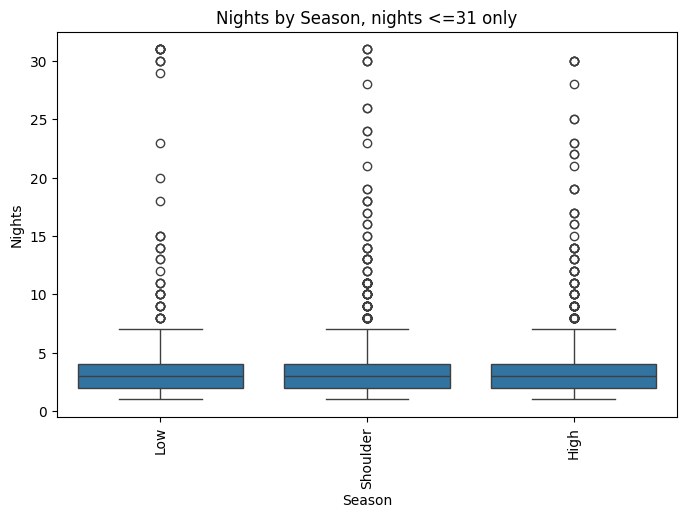

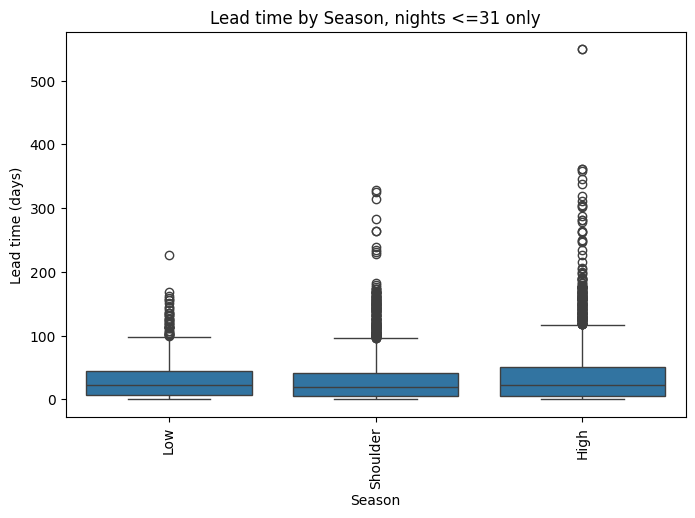

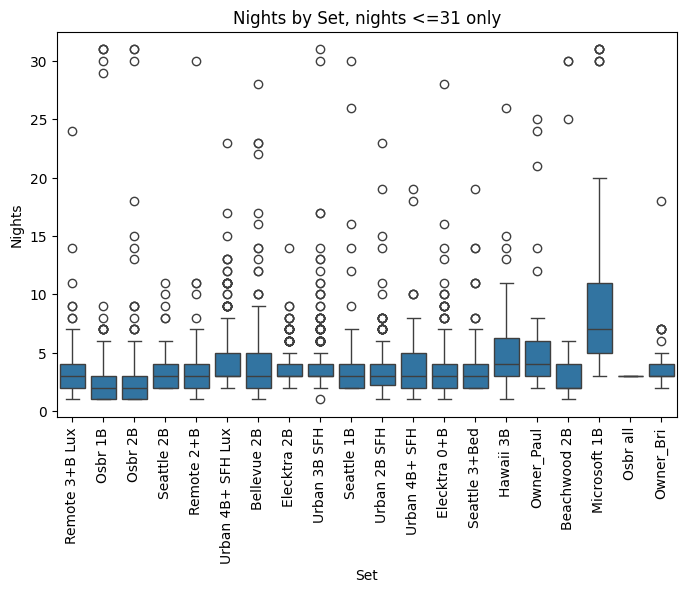

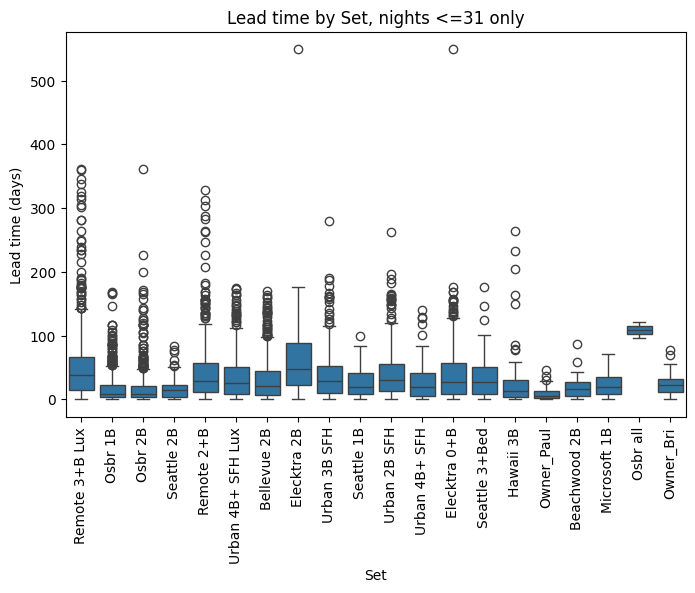

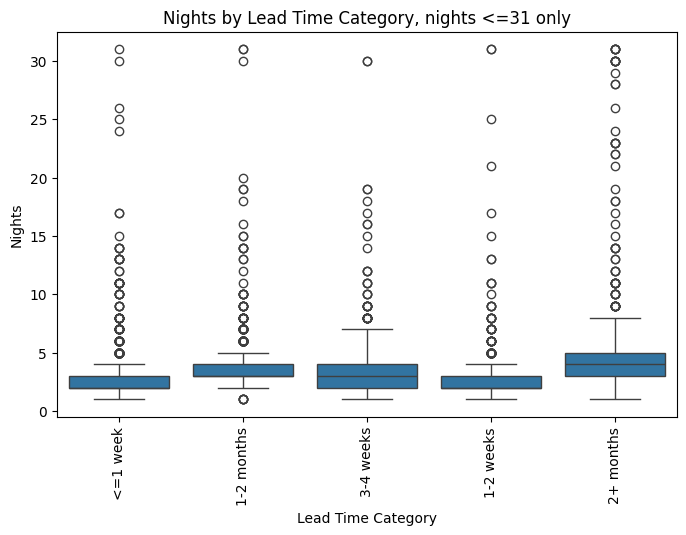

In [55]:
## length of stay report and lead time report
data_str = data_adr.loc[(data_adr["Status"]=="Active") & (data_adr["Type"]=="STR") & (data_adr["nights"]<=31)].copy()
data_str["Year"]=data_str["checkin_date"].dt.strftime("%Y")
data_str["Month"]=data_str["checkin_date"].dt.strftime("%m")
data_str["Season"]=np.where(data_str["Month"].isin(["01","02","03"]),"Low",
                    np.where(data_str["Month"].isin(["04","05","10","11","12"]),"Shoulder","High"))
data_str["LeadTimeCategory"] = np.where(data_str["lead_time"]<=7,"<=1 week",
                                        np.where(data_str["lead_time"]<=14,"1-2 weeks",
                                 np.where(data_str["lead_time"]<=30,"3-4 weeks",
                        np.where(data_str["lead_time"]<60,"1-2 months","2+ months"))))

rangeStay = (data_str 
             .groupby(["Listing"],as_index=False)
             .agg(minStay=("nights","min"),
                 maxStay=("nights","max"),
                 avgStay=("nights","mean"),
                 medStay=("nights","median"),
                 bookings =("Confirmation.Code","nunique"),
                 start_date=("checkin_date","min"),
                 endd_ate=("checkout_date","max")))
rangeStay = safe_round(rangeStay, ndigits=0)

rangeStay_Set = (data_str 
                 .groupby(["Set"],as_index=False)
                 .agg(minStay=("nights","min"),
                     Stay05=("nights",lambda x: x.quantile(0.05)),
                     Stay10=("nights",lambda x: x.quantile(0.10)),
                     Stay16=("nights",lambda x: x.quantile(0.16)),
                     medStay=("nights","median"),
                     Stay84=("nights",lambda x: x.quantile(0.84)),
                     Stay90=("nights",lambda x: x.quantile(0.90)),
                     Stay95=("nights",lambda x: x.quantile(0.95)),
                     maxStay=("nights","max")))
rangeStay_Set = safe_round(rangeStay_Set, ndigits=0)

rangeStay_Set

plt.figure(figsize=(8, 5))
sns.boxplot(data=data_str, x="Season", y="nights")
plt.title("Nights by Season, nights <=31 only")
plt.xlabel("Season")
plt.xticks(rotation=90)
plt.ylabel("Nights")
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data=data_str, x="Season", y="lead_time")
plt.title("Lead time by Season, nights <=31 only")
plt.xlabel("Season")
plt.xticks(rotation=90)
plt.ylabel("Lead time (days)")
plt.show()


plt.figure(figsize=(8, 5))
sns.boxplot(data=data_str, x="Set", y="nights")
plt.title("Nights by Set, nights <=31 only")
plt.xlabel("Set")
plt.xticks(rotation=90)
plt.ylabel("Nights")
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data=data_str, x="Set", y="lead_time")
plt.title("Lead time by Set, nights <=31 only")
plt.xlabel("Set")
plt.xticks(rotation=90)
plt.ylabel("Lead time (days)")
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data=data_str, x="LeadTimeCategory", y="nights")
plt.title("Nights by Lead Time Category, nights <=31 only")
plt.xlabel("Lead Time Category")
plt.xticks(rotation=90)
plt.ylabel("Nights")
plt.show()

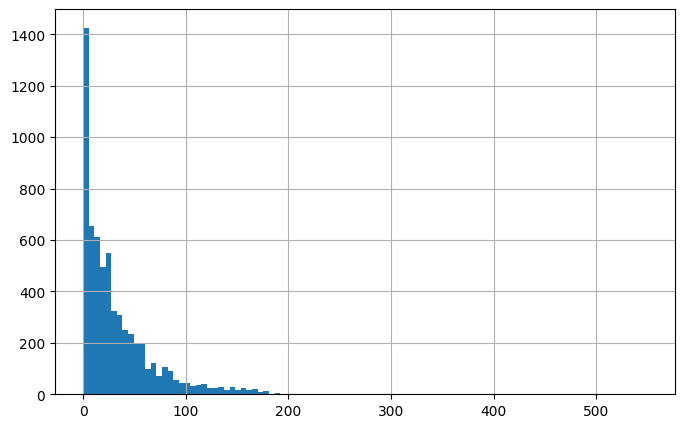

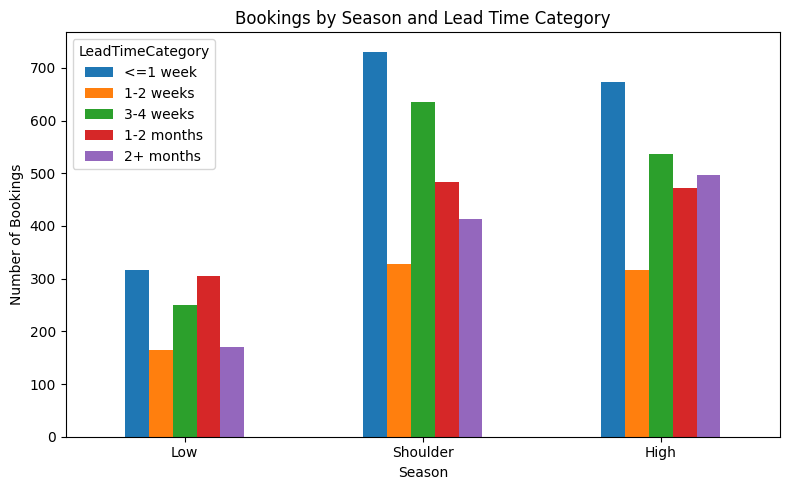

In [56]:

#data_str['nights'].hist(bins=31, figsize=(8, 5))

data_str["lead_time"].hist(bins=100, figsize=(8, 5))
data_str["nights"].describe()
data_str["lead_time"].describe()

#data_str.loc[data_str["lead_time"]<=1,["Listing","Confirmation.Code","checkin_date","confirmation_date","lead_time"]]

data_str.groupby(["LeadTimeCategory"]).size()

leadtime_order = [
    "<=1 week",
    "1-2 weeks",
    "3-4 weeks",
    "1-2 months",
    "2+ months"
]
season_order = ["Low","Shoulder","High"]
ct=data_str.groupby(["LeadTimeCategory","Season"]).size().unstack(fill_value=0)
ct = ct.reindex(leadtime_order)
ct = ct.reindex(columns=season_order)
ax = ct.T.plot(
    kind="bar",
    figsize=(8, 5)
)

ax.set_xlabel("Season")
ax.set_ylabel("Number of Bookings")
ax.set_title("Bookings by Season and Lead Time Category")

plt.xticks(rotation=0)
plt.legend(title="LeadTimeCategory")
plt.tight_layout()
plt.show()

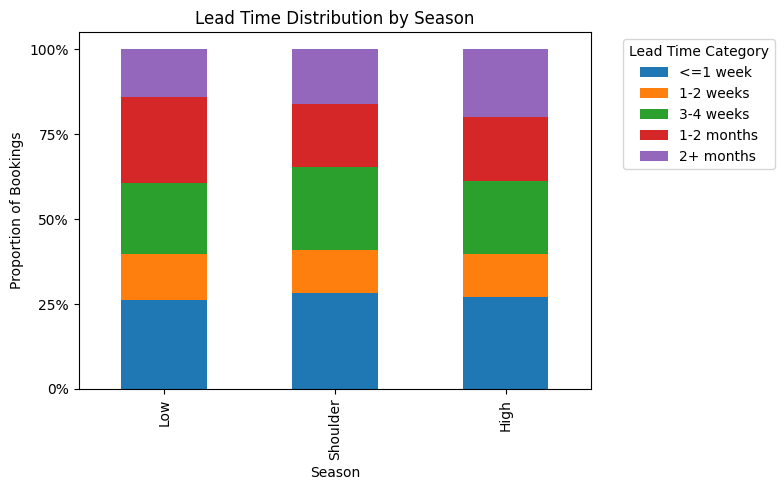

In [57]:
ct_prop = ct.div(ct.sum(axis=0), axis=1)
ax = ct_prop.T.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 5)
)

ax.set_xlabel("Season")
ax.set_ylabel("Proportion of Bookings")
ax.set_title("Lead Time Distribution by Season")

# Optional: show percentages on y-axis
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(["0%", "25%", "50%", "75%", "100%"])

plt.legend(title="Lead Time Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [45]:
# Add ADR range to yearly_tab
yearly_tab = yearly_tab.merge(rangeADR,on="Listing",how="left")
yearly_tab = safe_round(yearly_tab, ndigits=2)

In [46]:
## Only include the month till today 
#months_excl = [12]
#lastdate = "-12-31"
#lastdays = [sum([monthrange(2024,m)[1] for m in months_excl]),
#            sum([monthrange(2025,m)[1] for m in months_excl])]
lastdays =[0,0] # for 2025.12

yearly_todate = monthly.loc[monthly["Month"].isin([str(x) for x in months_excl])==False].groupby(["Listing","Year"],as_index=False).agg(
    nights =("occdays","sum"),
    Revenue =("Revenue","sum"),
    ADR =("avgADR","mean")  # placeholder,
)
#yearly_todate["ADR"] = yearly_todate["ADR"] / yearly_todate["nights"]
yearly_todate["OccRt"] = yearly_todate["nights"] / yearly_todate["Year"].\
    apply(lambda y: 366 - lastdays[0] if int(y)%4==0 else 365 - lastdays[1])
yearly_todate = safe_round(yearly_todate, ndigits=2)

yearly_todate_tab = yearly_todate[yearly_todate["Year"].isin(["2024","2025"])].\
    pivot(index="Listing",  columns="Year",
          values=["Revenue","ADR","OccRt"]).reset_index()

yearly_todate_tab.columns = ["Listing",*cols]
#yearly_todate_tab = combine_osbr_beachwood(yearly_todate_tab)
yearly_todate_tab = safe_round(yearly_todate_tab, ndigits=2)
yearly_todate_tab["Revenue_ratio_today"] = yearly_todate_tab["Revenue_2025"]/yearly_todate_tab["Revenue_2024"]
yearly_todate_tab["Revenue_hlt_today"] = np.where(yearly_todate_tab["Revenue_ratio_today"]<0.95,"Loss","")


In [47]:
yearly_tab = yearly_tab.merge(yearly_todate_tab[["Listing",
        "Revenue_2025","Revenue_ratio_today","Revenue_hlt_today"]],
        on="Listing",how="left",suffixes=["","_today"])
OwnerPayout.columns=["Listing","OwnerDist_2024","OwnerDist_2025"]
yearly_tab = yearly_tab.merge(OwnerPayout,on="Listing",how="left")

property = property_input()
yearly_tab = property.loc[property["Status"]=="Active",["Listing","Type"]].\
    merge(yearly_tab,on="Listing")
#HTML(yearly_tab.to_html())

In [48]:
## Payout sheet creation
Payout = yearly_tab[["Listing","Revenue_2024","Revenue_2025", "Revenue_2025_today"]].merge(
                              OwnerPayout,on="Listing",how="outer").merge(
                      property[["Property","Listing","Type","Status"]],on="Listing",how="left")
Payout = Payout[Payout["Status"]=="Active"]
#Payout = combine_osbr_beachwood(Payout)
num_col = Payout.select_dtypes(include=[np.number]).columns

Payout_tab = Payout.groupby(["Property"],as_index=False).agg({c:"sum" for c in num_col})
for c in num_col:
        Payout_tab[c] = Payout_tab[c].replace(0, np.nan)
Payout_tab = safe_round(Payout_tab)
Payout_tab["owner_pay_perc_last"]  = Payout_tab["OwnerDist_2024"]  / Payout_tab["Revenue_2024"]
Payout_tab["owner_pay_perc_today"] = Payout_tab["OwnerDist_2025"] / Payout_tab["Revenue_2025_today"]
Payout_tab["Delta"] = Payout_tab["owner_pay_perc_today"] - Payout_tab["owner_pay_perc_last"]
Payout_tab["flag"] = np.where(
    Payout_tab["Delta"] < (-0.02),
    np.where(Payout_tab["Revenue_2025"] < Payout_tab["Revenue_2024"], "High", "Med"),"Low")
Payout_tab = safe_round(Payout_tab)
#set(property.loc[property["Status"]=="Active","Property"])-set(Payout_tab["Property"])
Payout_tab = property[["Property","Type"]].drop_duplicates(subset="Property").merge(Payout_tab,on="Property",how="right")
#set(property.loc[property["Status"]=="Active","Property"])-set(Payout_tab["Property"])

In [49]:
## Rating based on VA inputs on 9/28/2025
cur_path = "/Users/ylin/My Drive/Cohost/Data and Reporting/Data/Revenue/Property_OverallRatings.xlsx"
current = pd.read_excel(cur_path)
num_cols = [c for c in current.columns if re.search(r"(Number|Overall)",c)]
for c in num_cols:
    current[c] = pd.to_numeric(current[c], errors="coerce")
current[num_cols] = current[num_cols].round(2)
current["Extract Date"] = pd.to_datetime(current["Extract Date"], errors="coerce", unit="d")
current[num_cols] = current[num_cols].fillna(0)
current["Nreview"] = 0
current["Current_weighted_rating"] = 0 # placeholder

def fmt_rating(val, n):
    return np.where(~np.isin(val, [0, np.nan]), val.round(2).astype(str) + " (" + n.astype("Int64").astype(str) + ")", np.nan)
   
for k in ["Airbnb","VRBO","Booking"]:
    ncol = f"Number of reviews {k}"
    ocol =f"Overall {k}"
    idx = (current[ncol].isin([0,np.nan])) | (current[ocol].isin([0,np.nan]) & current[ncol].notna())
    current.loc[idx,ocol] = 0
    current.loc[idx,ncol] = 0
    if k!="Airbnb":
        current[ocol] = current[ocol]/2
    current["Nreview"]=current["Nreview"]+current[ncol]
    current["Current_weighted_rating"] = current["Current_weighted_rating"] + \
            current[ncol]*current[ocol]
    current[f"Current_rating_{k}"] = fmt_rating(current[ocol],current[ncol])

current["Current_weighted_rating"] = current["Current_weighted_rating"]/current["Nreview"]

In [50]:
 # Ratings pulled from Guesty + canceled bookings to enrich
ratings_path = "/Users/ylin/My Drive/Cohost/** Properties ** -- Valta/0_Cohosting/1-Reviews/Guesty reviews from Tech team/20260104 guesty_reviews.xlsx"
ratings = pd.read_excel(ratings_path)

canceled = pd.read_csv("/Users/ylin/My Drive/Cohost/Data and Reporting/Data/Revenue/GuestyCanceled.csv", na_values=["", " "])
col=canceled.columns
col =[re.sub(" |-|'",'.',c) for c in col]
canceled.columns = col
for col in ["NUMBER.OF.ADULTS","NUMBER.OF.CHILDREN","NUMBER.OF.INFANTS","PET.FEE"]:
    canceled[col] = np.nan
platforms = pd.read_excel("/Users/ylin/My Drive/Cohost/Data and Reporting/Data/Revenue/Source_Platform.xlsx")
canceled = canceled.merge(platforms, on="SOURCE", how="left")
canceled_fmt = format_reservation(canceled, "2017-01-01", "2025-12-31")
canceled_fmt["status"] = "canceled"
canceled_fmt["Term"] = "STR"
guestydata = data.copy()
guestydata['status'] = 'confirmed' 
guestydata = pd.concat([guestydata,canceled_fmt],ignore_index=True,sort=False)
ratings = ratings.merge(guestydata[["Listing","Confirmation.Code","status",'checkin_date','checkout_date','booking_platform']],
                         left_on="Reservation",right_on="Confirmation.Code",how='left')
ratings["createdAt"] = pd.to_datetime(ratings["createdAt"],errors="coerce")

# New ratings since 2025-09-28 → incremental averages per platform    
ratings_add = (ratings[ratings["createdAt"] > pd.Timestamp("2025-09-28")]
              .groupby(["Listing","booking_platform"],as_index=False)
              .agg(number=("Overall","count"),Overall=("Overall","mean"))
              .pivot(index="Listing",columns="booking_platform",values=["number","Overall"])
              .reset_index())
ratings_add.columns = ["_".join([c for c in col if c]).strip("_") for col in ratings_add.columns.to_flat_index()]
ratings_add["Overall_Booking"] = ratings_add["Overall_Booking.com"] / 2.0
ratings_add["number_Booking"] = ratings_add["number_Booking.com"]
cur_upd = current.merge(ratings_add, on ="Listing",how="outer")

cur_upd["Current_weighted_rating"] = cur_upd["Current_weighted_rating"] * cur_upd["Nreview"]
for k in ["Airbnb","VRBO","Booking"]:
    ncol = cur_upd[f"Number of reviews {k}"].fillna(0)
    ocol =cur_upd[f"Overall {k}"].fillna(0)
    ncol1 = cur_upd[f"number_{k}"].fillna(0)
    ocol1 = cur_upd[f"Overall_{k}"].fillna(0)
    num = (ncol*ocol)+(ncol1*ocol1)
    den = ncol+ncol1
    with np.errstate(divide="ignore", invalid="ignore"):
        cur_upd[f"Overall_{k}"] =  fmt_rating(num/den,den) 
    cur_upd["Nreview"] = cur_upd["Nreview"].fillna(0) + ncol1.fillna(0)
    cur_upd["Current_weighted_rating"] = cur_upd["Current_weighted_rating"].fillna(0) + (ncol1*ocol1)

cur_upd["Current_weighted_rating"] = cur_upd["Current_weighted_rating"]/cur_upd["Nreview"]
cur_upd = safe_round(cur_upd)

In [51]:
ratings["checkin_date"] = pd.to_datetime(ratings.get("checkin_date"), errors="coerce")
ratings_sum_yr = (
    ratings.assign(year=lambda d: d["checkin_date"].dt.year, month=lambda d: d["checkin_date"].dt.month)
    .query("year >= 2024")
    .groupby(["Listing","year","booking_platform"], as_index=False)
    .agg(reviews=("Overall","count"), overall=("Overall","mean"))
    .assign(Rating_reviews=lambda d: d["overall"].round(2).astype(str) + " (" + d["reviews"].astype(str) + ")")
    .pivot(index="Listing", columns=["year","booking_platform"], values="Rating_reviews")
    .reset_index()
)
ratings_sum_yr.columns = ["_".join([str(c) for c in col if c]).strip("_") for col in ratings_sum_yr.columns.to_flat_index()]

In [52]:
 # Merge ratings onto yearly_tab & flagging (as in R)
yearly_tab = yearly_tab.merge(ratings_sum_yr, on="Listing", how="left").merge(
    cur_upd[["Listing","Current_weighted_rating","Nreview","Current_rating_Airbnb","Current_rating_VRBO","Current_rating_Booking"]],
    on="Listing", how="left"
)
# Flag logic
# If Type == LTR => flag NA; else:
#   if Revenue_hlt_today == "Loss": High if rating<4.8 else Med
#   else Low if rating<4.8 else NA
def compute_flag(row):
    if row.get("Type") == "LTR":
        return np.nan
    loss = (row.get("Revenue_hlt_today") == "Loss")
    rating = row.get("Current_weighted_rating")
    if loss:
        return "High" if (pd.notna(rating) and rating < 4.8) else "Med"
    return "Low" if (pd.notna(rating) and rating < 4.8) else np.nan

yearly_tab["flag"] = yearly_tab.apply(compute_flag, axis=1)
years_cols = ['Listing', 'Type', 'Revenue_2024', 'ADR_2024','OccRt_2024',
        'Revenue_2025', 'Revenue_2025_today', 'ADR_2025', 'OccRt_2025', 
        '2024.0_Airbnb', '2024.0_Booking.com', '2024.0_VRBO', '2025.0_Airbnb',
       '2025.0_Booking.com', '2025.0_VRBO', 'Current_weighted_rating',
       'Current_rating_Airbnb', 'Current_rating_VRBO','Current_rating_Booking','Nreview', 
       'Revenue_ratio_today', 'Revenue_hlt_today','flag',
       'minADR', 'maxADR', 'avgADR','medADR','OwnerDist_2024', 'OwnerDist_2025']

yearly_tab = yearly_tab[years_cols]
payout_cols =['Property', 'Type', 'Revenue_2024', 'OwnerDist_2024',
               'Revenue_2025', 'Revenue_2025_today',  'OwnerDist_2025',
                'owner_pay_perc_last', 'owner_pay_perc_today', 'Delta', 'flag']
Payout_tab = Payout_tab[payout_cols]

In [53]:
# Output
out = {
    "yearly": yearly_tab,         # includes ratings & flags above
    "payout": Payout_tab,
    "monthly": monthly_tab,
    "monthly_long": monthly.assign(Year=lambda d: d["Year"].astype(int),
                                            Month=lambda d: d["Month"].astype(int)),
    "Ranges": Ranges,
}

In [54]:
with pd.ExcelWriter("/Users/ylin/My Drive/Cohost/Data and Reporting/RevenueReport_upd.xlsx", engine="openpyxl") as ew:
    for name, df in out.items():
        df.to_excel(ew, sheet_name=name[:31], index=False, na_rep="")
